<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/SkimLit-Chrome-Extension/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Skimlit
The propose of this project is to built an NLP model to make reading medical abstract easier.

The paper we are replicating (the source of dataset that we'll be using) is available here: https://arxiv.org/pdf/1710.06071


In [53]:
!nvidia-smi -L


/bin/bash: line 1: nvidia-smi: command not found


## Get the data
PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts https://github.com/Franck-Dernoncourt/pubmed-rct

In [54]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [55]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [56]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os
filename=[data_dir+filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [57]:
# Preprocess data
def get_lines(filename):
  with open(filename) as file:
    return file.readlines()

In [58]:
train_lines=get_lines(filename[0])
train_lines[:30]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [59]:
def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename)
  abstract_line=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_line=""

    elif line.isspace():
      abstract_line_split=abstract_line.splitlines()
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_line+=line
  return abstract_samples

In [60]:
train_samples=preprocess_text_with_line_numbers(filename[2])
test_samples=preprocess_text_with_line_numbers(filename[1])
validation_sample=preprocess_text_with_line_numbers(filename[0])

len(train_samples),len(test_samples),len(validation_sample)

(30212, 180040, 30135)

In [61]:
train_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

In [62]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(validation_sample)
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


# Distribution of labels in the training data


In [63]:
train_df.target.value_counts()

,count
target,
METHODS,9964
RESULTS,9841
CONCLUSIONS,4582
BACKGROUND,3449
OBJECTIVE,2376


It seems like the abstract talks mostly about Methods and Results and less about Objective

<Axes: ylabel='Frequency'>

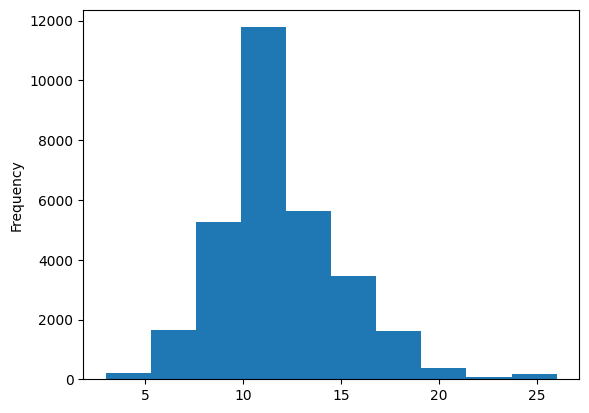

In [64]:
train_df.total_lines.plot.hist()

From this Histogram, it seems like most of the abstract has the length of 7-18

# Converting the abstract lines into list

In [65]:
train_sentences=train_df.text.to_list()
test_sentences=test_df.text.to_list()
validation_sentences=val_df.text.to_list()
validation_sentences[:10]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

# Make numeric labels
Lets make one-hot and label encoded labels. TF CategoricalCrossentropy loss function likes to have one hot encoded labels

In [66]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot=one_hot_encoder.fit_transform(val_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot[:10],train_labels_one_hot[:10],test_labels_one_hot[:10]


(array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]))

# label encode labels

In [67]:
# Extract target columns and encode into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels=label_encoder.fit_transform(train_df.target.to_numpy())
test_labels=label_encoder.fit_transform(test_df.target.to_numpy())
validation_labels=label_encoder.fit_transform(val_df.target.to_numpy())
train_labels[:10],test_labels[:10],validation_labels[:10]

(array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1]),
 array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4]),
 array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0]))

In [68]:
# Get the names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [69]:
train_labels

array([0, 0, 3, ..., 4, 1, 1])

# Model 0: Baseline
TF-IDF Multinomial Naive Bayes Classifier

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([("tf-idf",TfidfVectorizer()),
                  ("clf",MultinomialNB()),
                  ])
# Fit the pipeline
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [71]:
# Evaluate baseline model
model_0.score(X=validation_sentences,y=validation_labels)

0.6755931640949062

In [72]:
# make prediction
baseline_preds=model_0.predict(validation_sentences)
baseline_preds[:10]

array([2, 2, 2, 4, 4, 4, 4, 1, 4, 1])

In [73]:
validation_labels[:10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [74]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py


--2025-05-22 19:18:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-22 19:18:13 (47.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [75]:
from helper_functions import calculate_results


In [76]:
# calculate baseline results
baseline_results=calculate_results(y_true=validation_labels,y_pred=baseline_preds)
baseline_results

{'accuracy': 67.55931640949062,
 'precision': 0.6707354792180861,
 'recall': 0.6755931640949062,
 'f1': 0.6337858496380698}

Model 1: simple Dense Model

In [77]:
# create tensorboard callback
from helper_functions import create_tensorboard_callback
SAVE_DIR="model_logs"


 Lets create a text vectorization and embedding layers. The vectorization layer convert the text into numbers and the embedding layer will capture the relationship between those numbers

In [78]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

In [79]:
max_vocab_length=sum([len(i.split()) for i in train_sentences])
max_vocab_length

798275

(array([2.4876e+04, 4.9100e+03, 3.6000e+02, 5.3000e+01, 8.0000e+00,
        3.0000e+00, 2.0000e+00]),
 array([  1.        ,  37.71428571,  74.42857143, 111.14285714,
        147.85714286, 184.57142857, 221.28571429, 258.        ]),
 <BarContainer object of 7 artists>)

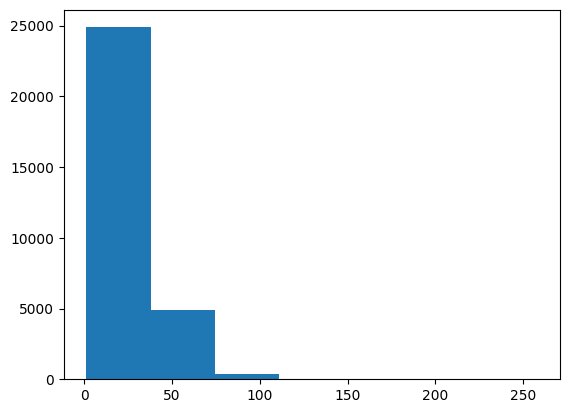

In [80]:
# Lets check the distribution of the sentence length
import matplotlib.pyplot as plt
sentence_lengths=[len(i.split()) for i in train_sentences]
plt.hist(sentence_lengths,bins=7)

In [81]:
# How long of a sentence covers 95% of the lengths?
import numpy as np
output_sen_len=int(np.percentile(sentence_lengths,95))
output_sen_len

55

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.



In [82]:
import tensorflow as tf

max_length=55
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=68000,
                                                  output_sequence_length=max_length)


let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.



In [83]:
text_vectorizer.adapt(train_sentences)

In [84]:
# Testing our text vectorizer
import random
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
correlations between the carer boa and the survivor hads-a ( r = @ , p < @ ) and the survivor boa ( r = @ , p < @ ) demonstrated construct validity .        

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[2248,   28,    2, 5628, 4825,    3,    2, 4561, 9969,  639,   14,
           3,    2, 4561, 4825,  639,   14,  319, 3947, 1976,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [85]:
# how many words are there in the vocabolary
rct_20k_vocab=text_vectorizer.get_vocabulary()
len(rct_20k_vocab)

25008

In [86]:
# Get the configuration of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 25008}

In [87]:
len(rct_20k_vocab)

25008

In [88]:
embeddings=tf.keras.layers.Embedding(input_dim=len(rct_20k_vocab), # length of vocabolary
                                     output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                                     mask_zero=True, # Use masking to handle variable sequences lengths
                                     name="embedding")


In [89]:
# Testing our text vectorizer
import random
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
print(text_vectorizer([random_sentence]))

# testing our embedding
print("########## After embeddings #########")
after_embeddings=embeddings(text_vectorizer([random_sentence]))
after_embeddings,after_embeddings.shape

Original text:
in pc patients , t decreased to less than @ ng/dl in four of five patients dosed with @ or @ mg tak-@ sc-depot injections .        

Vectorized version:
tf.Tensor(
[[    5  1315    11   213   221     6   204    45 14193     5   263     4
    469    11  4453     7    15    69  3232 18078  1236     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)
########## After embeddings #########


(<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[-0.00463668,  0.03879081,  0.04034635, ...,  0.01104916,
           0.01626847, -0.01454734],
         [ 0.01879865,  0.0093262 , -0.03570247, ..., -0.03487559,
           0.02271756,  0.03712735],
         [-0.01197962,  0.03816154, -0.02271936, ..., -0.03155835,
          -0.01418024, -0.03320513],
         ...,
         [ 0.00455339, -0.04095858,  0.02405326, ..., -0.02334948,
           0.04199547, -0.03351649],
         [ 0.00455339, -0.04095858,  0.02405326, ..., -0.02334948,
           0.04199547, -0.03351649],
         [ 0.00455339, -0.04095858,  0.02405326, ..., -0.02334948,
           0.04199547, -0.03351649]]], dtype=float32)>,
 TensorShape([1, 55, 128]))

To create a batched PrefetchDataset we can use the methods betch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow Tensowflow to determine the optimal amount of compute to use to prepare datasets

In [90]:
# Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
validation_dataset=tf.data.Dataset.from_tensor_slices((validation_sentences,validation_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [91]:
# Take the tensor slices and turn them in to prefetch Batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Model 1: Conv1D with token embeddings

Input(text)-> Tokenize-> Embeddings -> Layers -> Output (label Probalility)

In [94]:
# Build a model with Functional API
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
x=layers.Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1_dense")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary(
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 55, 128)        │     3,201,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,242,373 (12.37 MB)

 Trainable params: 3,242,373 (12.37 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Fit the model
model_1_history=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)), # Only fit 10% of the batches for the faster training time
                            epochs=5,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(validation_dataset))
                            )

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.3364 - loss: 1.4818 - val_accuracy: 0.5227 - val_loss: 1.2380
Epoch 2/5
 3/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.3941 - loss: 1.3346

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5761 - loss: 1.0963 - val_accuracy: 0.6387 - val_loss: 0.8983
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.6735 - loss: 0.8530 - val_accuracy: 0.6927 - val_loss: 0.7817
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.7020 - loss: 0.7649 - val_accuracy: 0.7156 - val_loss: 0.7421
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.7173 - loss: 0.7407 - val_accuracy: 0.7252 - val_loss: 0.7185


In [96]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7232 - loss: 0.7213


[0.7185485363006592, 0.725203275680542]

In [97]:
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

  1/942 ━━━━━━━━━━━━━━━━━━━━ 4:51 310ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


array([[0.61661035, 0.53641105, 0.34607208, 0.45960099, 0.13928337],
       [0.23396134, 0.17993161, 0.87463367, 0.31808433, 0.1613533 ],
       [0.0231942 , 0.06282102, 0.99609363, 0.04728227, 0.83408046],
       ...,
       [0.08051813, 0.53070194, 0.5366925 , 0.05919163, 0.94382155],
       [0.20590504, 0.44827524, 0.6878836 , 0.10421861, 0.895229  ],
       [0.10390222, 0.5928146 , 0.2464232 , 0.14554569, 0.6400348 ]],
      dtype=float32)

In [100]:
model_1_results=calculate_results(y_true=validation_labels,y_pred=tf.argmax(model_1_pred_probs,axis=1))
model_1_results

{'accuracy': 72.52032520325203,
 'precision': 0.7216876064143259,
 'recall': 0.7252032520325203,
 'f1': 0.7089252542853896}

# Model 2: Transfer Learning
The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)


There is lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

In [101]:
# download the pretrained USE
import tensorflow_hub as hub
tf_hub_embeddings=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="Universal_sentence_encoder"

                                )


In [103]:
# lets test this pretrained embedding on a random sentence
tf_hub_embeddings([random_sentence])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.07844821,  0.06734816,  0.02839016, -0.04064916, -0.04261599,
         0.0440459 ,  0.05197147, -0.00521057, -0.07299194, -0.04925877,
         0.08669516, -0.01751706,  0.04993707,  0.06676433,  0.06228294,
         0.04104807, -0.08704939, -0.05374593, -0.01022631,  0.03287023,
         0.07375883, -0.02269134, -0.01667795, -0.00526111,  0.00653952,
         0.0156289 ,  0.0163584 , -0.07309781,  0.02080171, -0.05269661,
         0.00509712,  0.08705998, -0.02386393,  0.04712711,  0.04264718,
        -0.00863698,  0.04295269, -0.01116588,  0.00741646, -0.05697229,
         0.07500141,  0.08282559, -0.03923724, -0.0063359 ,  0.05565286,
         0.03031596,  0.03973894,  0.04698449,  0.01388062,  0.05466845,
        -0.07270743, -0.05112611, -0.02062477, -0.0453585 , -0.06047026,
         0.00943117, -0.07949771, -0.00552112, -0.06571347, -0.03001788,
        -0.01609073,  0.04420922, -0.05295012,  0.05618093, -0.0352218 ,
 

In [105]:
# length of embedding
len(tf_hub_embeddings([random_sentence])[0])

512

In [112]:
# inputs = layers.Input(shape=[], dtype=tf.string)
# pretrained_embedding = tf_hub_embeddings(inputs) # tokenize text and create embedding
# x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# # Note: you could add more layers here if you wanted to
# outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
# model_2 = tf.keras.Model(inputs=inputs,
#                         outputs=outputs)

# # Compile the model
# model_2.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [115]:
# Building and fitting an NLP feature extraction model from TF Hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Wrap USE inside a custom Keras Layer
class USEEmbedding(tf.keras.layers.Layer):
    def __init__(self, trainable=False, **kwargs):
        super(USEEmbedding, self).__init__(trainable=trainable, **kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Keras Input (1D: batch of strings)
input_text = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")

# Embed using our wrapped USE Layer
embedding = USEEmbedding()(input_text)

# Add classification layers
x = layers.Dense(128, activation="relu")(embedding)
output = layers.Dense(num_classes, activation="sigmoid")(x)

# Build model
model_2 = Model(inputs=input_text, outputs=output)
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Show model summary
model_2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding_3 (USEEmbedding)  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=5,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset))
            )

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.4147 - loss: 0.5729 - val_accuracy: 0.5688 - val_loss: 0.3748
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5778 - loss: 0.3580 - val_accuracy: 0.6346 - val_loss: 0.3217
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6399 - loss: 0.3160 - val_accuracy: 0.6712 - val_loss: 0.3046
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6729 - loss: 0.3002 - val_accuracy: 0.6742 - val_loss: 0.2954
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6599 - loss: 0.3034 - val_accuracy: 0.6862 - val_loss: 0.2875
